# Title: Predicting Risk of Heart Disease Using Classification #
Group 14:
Jackie Hagstrom,
Hannah Reyes,
Mikayla Ditosto,
Minal Nijhawan 

# Introduction #

In Ohio, heart disease claimed over 26,000 lives in 2016, making it the 13th state with high heart disease mortality (Heart Disease, 2016). To better predict heart disease in patients, our group focused on analyzing heart disease data specific to Cleveland, Ohio (Heart Disease, 2016). The dataset we used is sourced from the UC Irvine Machine Learning Repository and combines information from various medical institutions. Our analysis centers on the Cleveland dataset, which assigns a scale of 0-4 to indicate the presence and severity of heart disease (0 meaning no risk and 4 denoting the highest risk). A value of 0 signifies less than 50% diameter narrowing, while 1 indicates more than 50% diameter narrowing in any major vessel.

Our project aims to determine which variables are crucial for classifying a person's risk of heart disease in Cleveland. To accomplish this, we employ the K-nearest neighbors machine-learning algorithm. Since the response variable (num) is categorical, we treat this as a classification problem. K-NN calculates the straight-line distance between unlabeled data and labeled examples in the training data, selecting the "K" nearest neighbors. The most frequent label among these neighbors is assigned to the unlabeled data point. We optimize the model's performance by tuning the K value through cross-validation, finding the optimal value that yields the highest predictive accuracy on the training data and applying it to the testing data.

The original dataset had 303 rows and after filtering NA values it decreased to 297. Although the dataset provides 14 variables for detecting heart disease risk, we selectively choose variables to construct our classification model. Throughout our analysis, we provide justifications for excluding certain variables. 

Refer to the bottom of this document for the meanings of the variables.

## Methods & Results ##

**Preliminary Exploratory Data Analysis**

In [64]:
library(tidyverse)
library(repr)
library(tidymodels)

In [65]:
# dataset was read into R
set.seed(2023)
cleveland_data <- read_csv("https://raw.githubusercontent.com/mikayladitosto/dsci-100-2023s1-group-14/main/processed.cleveland.data", col_names = FALSE)
colnames(cleveland_data) <- c("age",
                              "sex",
                              "cp",
                              "trestbps",
                              "chol",
                              "fbs",
                              "restecg",
                              "thalach",
                              "exang",
                              "oldpeak",
                              "slope",
                              "ca",
                              "thal",
                              "num")

# changed data types of columns to be able to perform classification and EDA
cleveland_data <- cleveland_data |>
    mutate(num = as_factor(num),
           ca = as.numeric(ca),
           thal = as.numeric(thal))

# removed N/A ("?") values from the dataset
cleveland_data <- cleveland_data |>
    filter(age != "?",
           sex != "?",
           cp != "?",
           trestbps != "?",
           chol != "?",
           fbs != "?",
           restecg != "?",
           thalach != "?",
           exang != "?",
           oldpeak != "?",
           slope != "?",
           ca != "?",
           thal != "?"
          )

head(cleveland_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `ca = as.numeric(ca)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0


Table 1: Cleaned dataset with the original 14 variables

We downloaded the Cleveland data set and uploaded it to GitHub through our shared repository. After this step, we copied the URL into R, and we were able to read it with the read_csv function. Demonstrating that the dataset can be read from the web into R. 

In [66]:
# split the data into training and testing splits
cleveland_split <- initial_split(cleveland_data, prop = 0.75, strata = num)
cleveland_training <- training(cleveland_split)
cleveland_testing <- testing(cleveland_split)

We split the data into a training and testing set using the initial_split function so when we begin our analysis, we can build the classification model using the training set and then evaluate our model and determine its accuracy by using the testing set. We split 75% = training set and 25% = testing set using the prop argument.

In [67]:
num_obs <- nrow(cleveland_training)
cleveland_training |>
group_by(num) |>
summarize(count = n(),percentage = n() / num_obs * 100)

num,count,percentage
<fct>,<int>,<dbl>
0,120,54.298643
1,40,18.099548
2,26,11.764706
3,26,11.764706
4,9,4.072398


Table 2: Count of observations in each category (num)

This table shows us the number of observations in each category of heart disease. There is not an equal amount of people in each category, meaning our graphs can look disproportionate. In our classification analysis, we will make the classes proportionate by using class balancing to ensure the rarer classes are equally represented.

In [68]:
cleveland_mean <- cleveland_training |>
    group_by(num) |>
    summarise(mean_age = mean(age),
              mean_trestbps = mean(trestbps),
              mean_chol = mean(chol),
              mean_thalach = mean(thalach),
              mean_exang = mean(restecg),
              mean_oldpeak = mean(oldpeak))
cleveland_mean

num,mean_age,mean_trestbps,mean_chol,mean_thalach,mean_exang,mean_oldpeak
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,52.44167,129.3417,244.1917,158.8250,0.8583333,0.5966667
1,55.07500,132.7250,247.9000,146.4000,1.0500000,1.0200000
2,58.07692,135.8462,276.4231,131.6154,0.8846154,1.9000000
3,55.69231,134.1154,248.7308,133.1538,1.4230769,2.1230769
4,58.66667,139.8889,273.4444,143.5556,1.4444444,2.4000000


Table 3: Mean values for quantitative variables

We excluded categorical variables (sex, cp, exang, slope, thal, ca, fbs) from our analysis because the KNN algorithm we employed does not support categorical data. However, these variables may still have a substantial impact on the development of heart disease.

The mean values for oldpeak (ST depression induced by exercise) seem to increase with higher degree of heart disease (num: 0-4). 

The mean values for age, trestbps (resting blood pressure), chol (cholesterol), exang (exercise induced angina), thalach (maximum heart rate) and chol (cholesterol) do not have a consistent relationship (ie either decreasing or increasing) with a higher degree of heart disease (num: 0-4). 

**Graphs**

To explore the relationship between the predictor variables and the degree of heart disease, we utilized box plots. We chose this visualization method to observe patterns in the medians and variability across different degrees of heart disease. Below, we present five box plots representing the quantitative, continuous variables. These plots offer insights into potential associations between these variables and the severity of heart disease.

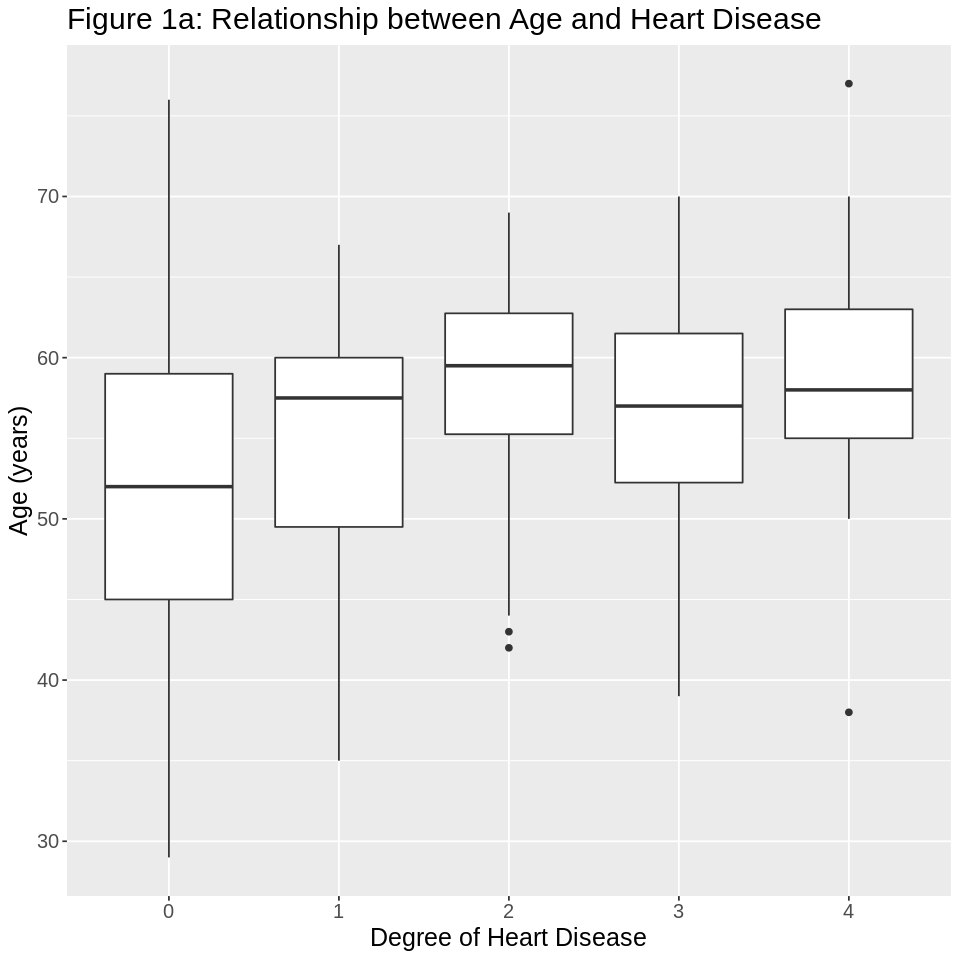

In [69]:
options(repr.plot.height = 8, repr.plot.width = 8)
age_plot <- cleveland_training |>
    ggplot(aes(y = age, x = num)) +
    geom_boxplot() +
    labs(x = "Degree of Heart Disease",
         y = "Age (years)") +
    theme(text = element_text(size = 15)) +
    ggtitle("Figure 1a: Relationship between Age and Heart Disease")
age_plot

In the graph, we depict the relationship between age and the degree of heart disease. The boxplots indicate that as the degree of heart disease rises, the variability in age decreases. Each degree of heart disease exhibits a distinct change in median age. The lowest median is in the absence of risk, around age 53. The absence of risk category also demonstrates the highest variability in age.

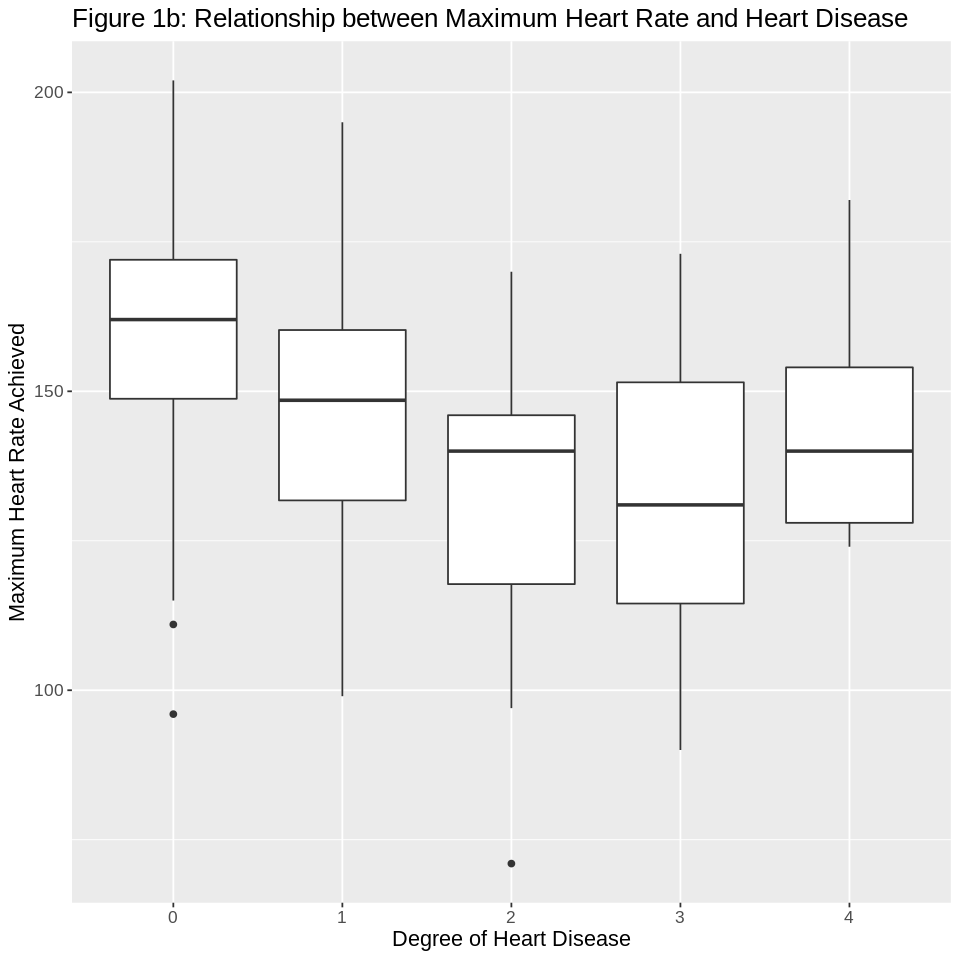

In [70]:
thalach_plot2 <- cleveland_training |>
    ggplot(aes(y = thalach, x = num)) +
    geom_boxplot() +
    labs(x = "Degree of Heart Disease",
         y = "Maximum Heart Rate Achieved") +
    theme(text = element_text(size = 13)) +
    ggtitle("Figure 1b: Relationship between Maximum Heart Rate and Heart Disease")
thalach_plot2

This graph depicts the relationship between the maximum heart rate achieved and each degree of heart disease. Notably, there is a decrease in medians from degrees 0 to 2. The fourth degree shows the least variability, but there is an increase in variability towards higher maximum heart rates. The lowest maximum heart rate is observed when the degree of heart disease is at 3, approximately 130 bpm.

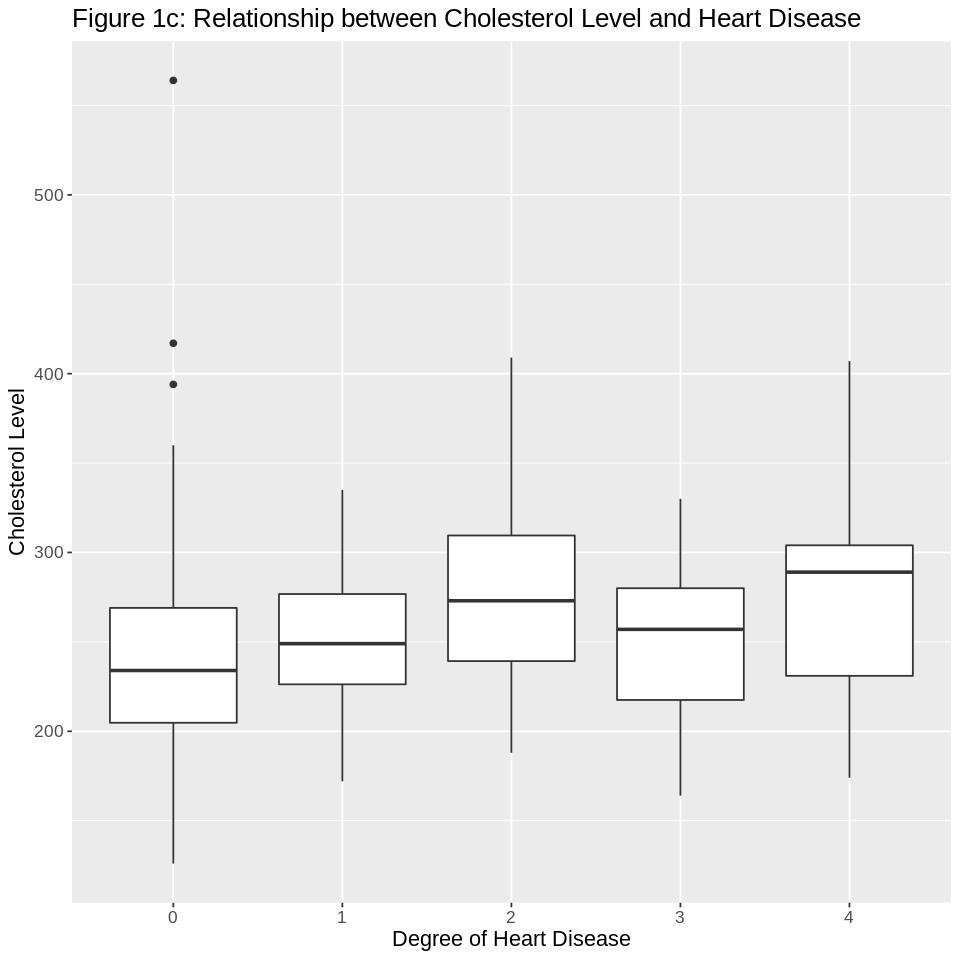

In [71]:
chol_plot <- cleveland_training |>
    ggplot(aes(y = chol, x = num)) +
    geom_boxplot() +
    labs(x = "Degree of Heart Disease",
         y = "Cholesterol Level") +
    theme(text = element_text(size = 13)) +
    ggtitle("Figure 1c: Relationship between Cholesterol Level and Heart Disease")
chol_plot

The box plot reveals that the cholesterol level alone does not provide a definitive indicator of the potential degree of heart disease risk. It examines the association between the numerical variable, Cholesterol Level, and the categorical variable, Degree of Heart Disease. The box plot demonstrates a significant overlap in the medians (around the 250-300 cholesterol level) across the different degrees of heart disease (degree 0-4), indicating a weaker relationship between the two variables. This finding aligns with Soliman's (2018) research, which emphasizes that the existing literature does not support the idea that dietary cholesterol increases the risk of heart disease in healthy individuals. Instead, ample evidence suggests that saturated fatty acids and trans-fat are the factors that contribute to cardiovascular disease risk. Therefore, the focus should be on exploring the relationship between saturated fatty acids, trans-fat, and the increased degree of heart disease risk rather than solely on cholesterol levels.

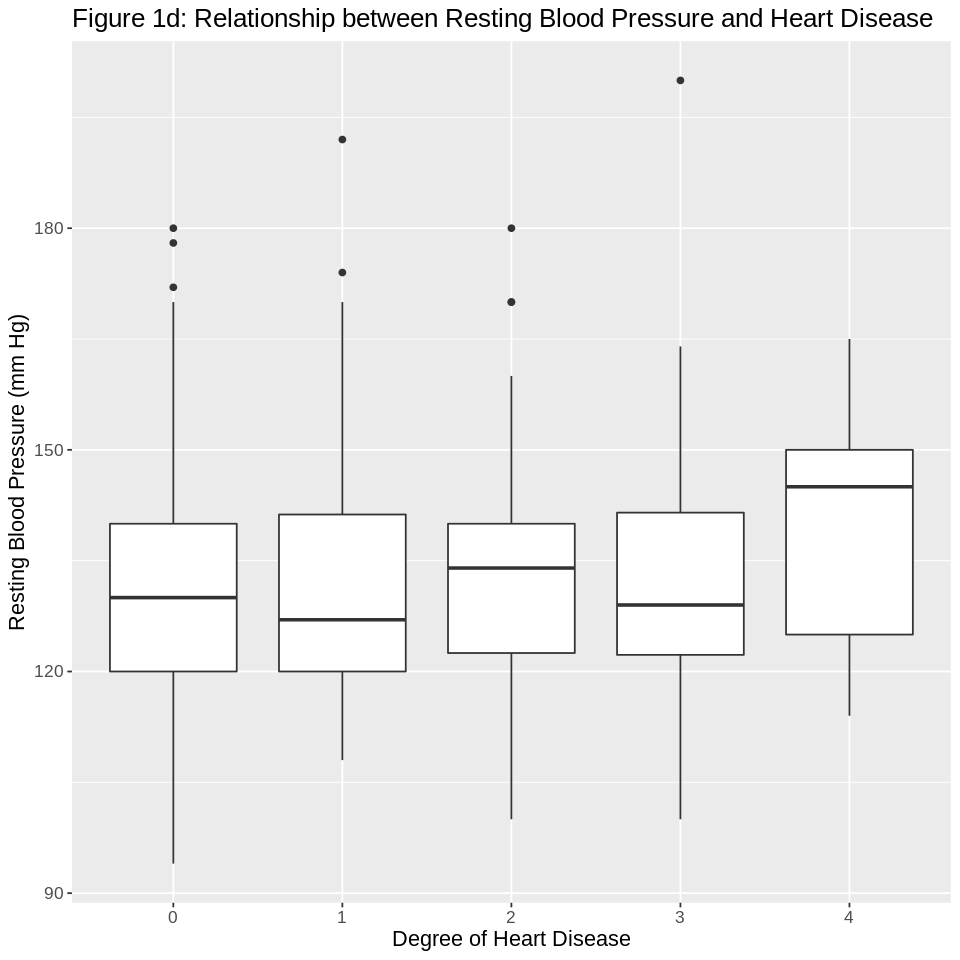

In [72]:
bp_plot <- cleveland_training |>
    ggplot(aes(y = trestbps, x = num)) +
    geom_boxplot() +
    labs(x = "Degree of Heart Disease",
         y = "Resting Blood Pressure (mm Hg)") +
    theme(text = element_text(size = 13)) +
    ggtitle("Figure 1d: Relationship between Resting Blood Pressure and Heart Disease")
bp_plot

The box plot illustrates the relationship between resting blood pressure and its predictive value for the degree of heart disease risk. It is evident from the box plot that the median resting blood pressure for degree 4 of heart disease is significantly higher than the median for the other degrees (degrees 0-3). This observation indicates a stronger association between the numerical variable, resting blood pressure, and the categorical variable, degree of heart disease. This finding aligns with the research conducted by Wu et al. (2015), which emphasizes that high blood pressure is one of the most crucial risk factors for cardiovascular disease, the leading cause of mortality.

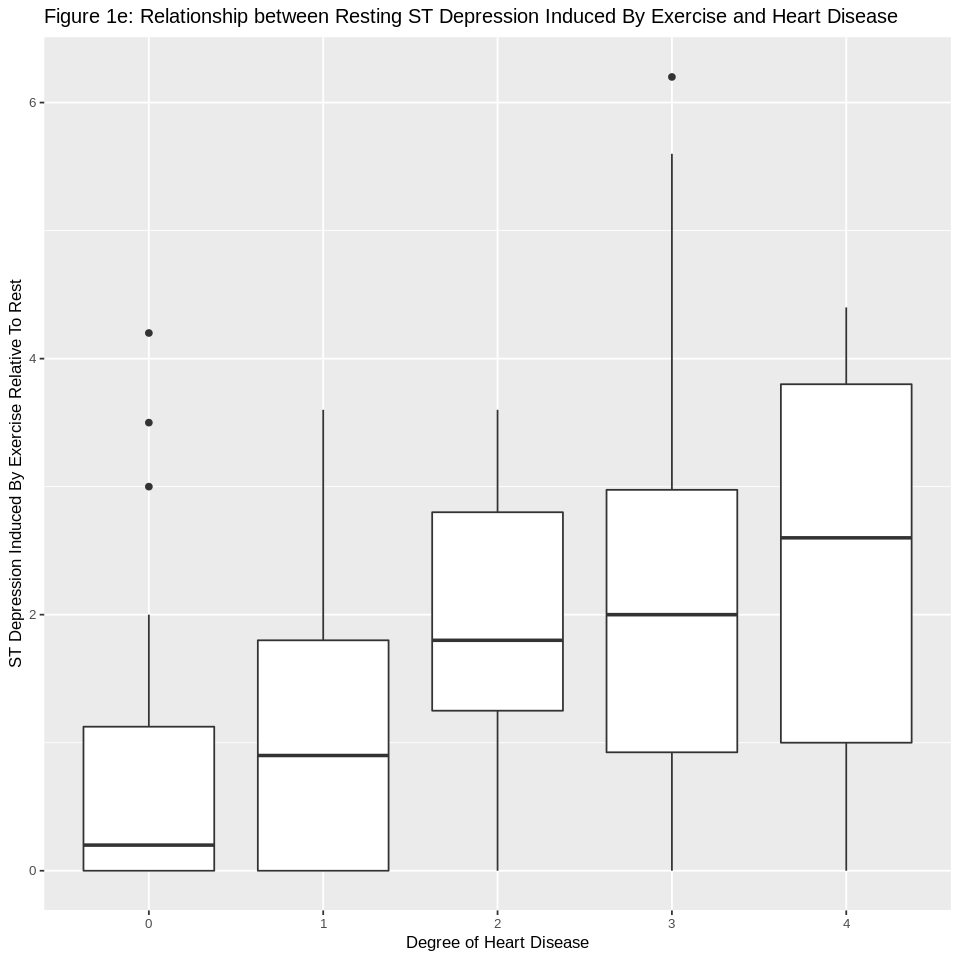

In [73]:
oldpeak_plot <- cleveland_training |>
    ggplot(aes(y = oldpeak, x = num)) +
    geom_boxplot() +
    labs(x = "Degree of Heart Disease",
         y = "ST Depression Induced By Exercise Relative To Rest") +
    theme(text = element_text(size = 10)) +
    ggtitle("Figure 1e: Relationship between Resting ST Depression Induced By Exercise and Heart Disease")
oldpeak_plot

This boxplot represents the ST depression induced by exercise in the degree of heart disease. An ST depression is found on EKG readings that measure heartbeat rhythms and electrical signals. The ST represents the segment between the S and T sections on the EKG report (Fletcher, 2022). A line close to the baseline is a sign of good health. When the ST is much lower than the baseline, ST depression signifies underlying health conditions (Fletcher, 2022). This graph’s scale represents the depression relative to the resting baseline. The larger the numbers get, the more deviation from the baseline. Zero is the baseline value. The degree of heart disease increases the more the ST deviates from the baseline. The degree of heart disease is the lowest when the deviation of ST is lower and closer to the baseline at zero. 

Variable Selection:

We selected ST depression induced by exercise (oldpeak) and maximum heart rate (thalach) as predictors for our final heart disease model. These variables exhibit a clear relationship with the degree of heart disease, making them suitable predictors for our classification analysis. On the other hand, age, resting blood pressure (trestbps), and cholesterol (chol) variables do not show a discernible relationship with the medians of the four classes of heart disease. Therefore, we decided to exclude them from our model.

**Building the Classification Model**

In [74]:
library(themis)
cleveland_recipe <- recipe(num ~ ., data = cleveland_training) |>
step_upsample(num, over_ratio = 1, skip = FALSE) |>
prep()

upsampled_cleveland <- bake(cleveland_recipe, cleveland_training)

count_upsampled <- upsampled_cleveland|>
group_by(num) |>
summarize(n= n())
count_upsampled

cleveland_recipe_2 <- recipe(num ~ thalach + oldpeak, data = upsampled_cleveland) |>
step_scale(all_predictors()) |>
step_center(all_predictors())

num,n
<fct>,<int>
0,120
1,120
2,120
3,120
4,120


Table 4: Balanced counts for each category (num)

Using the upsample function we balanced the class variable (num) so that there is an equal number of observations in each category (compared to table 2). We then created a recipe that specifies our predictor variables: thalach (maximum heart rate achieved) and old peak (resting ST depression induced by exercise) and the dataset we are using to build the model is upsampled_clevelend. We scaled the predictor variables so that there is no effect of the different scales on calculating Euclidean distances.

In [75]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
set_engine("kknn") |>
set_mode("classification")

We built our model specification by setting the weight_func argument to “rectangular” to specify straight line distance in the nearest_neighbor function. We also set neighbors = tune() so that we can apply cross-validation to determine a K value that results in the highest accuracy. Lastly, we set the engine to “kknn” (the R package to perform classification) and the mode to “classification”.

In [76]:
cleveland_wkflw <- workflow() |>
add_recipe(cleveland_recipe_2) |>
add_model(knn_spec)

We created a workflow, adding our recipe and model to chain together the steps to build our model.

In [77]:
set.seed(1)
gridvals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))
vfold_val <- vfold_cv(upsampled_cleveland, v = 5, strata = num)

We created a tibble specifying the K values we will be considering to use in our model (1-10). We used the vfold_cv function to specify the data set we will be using in cross validation: upsampled_cleveland along with the number of folds (5) and we included that we will be stratifying the data based upon num using the strata function.

In [78]:
cleveland_results <- cleveland_wkflw |>
tune_grid(resamples = vfold_val, grid = gridvals) |>
collect_metrics() |>
filter(.metric == "accuracy")
cleveland_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8533333,5,0.01911224,Preprocessor1_Model01
2,accuracy,multiclass,0.8533333,5,0.01911224,Preprocessor1_Model02
3,accuracy,multiclass,0.8350000,5,0.01034139,Preprocessor1_Model03
4,accuracy,multiclass,0.8350000,5,0.01452966,Preprocessor1_Model04
5,accuracy,multiclass,0.7866667,5,0.01699673,Preprocessor1_Model05
6,accuracy,multiclass,0.7733333,5,0.01379412,Preprocessor1_Model06
7,accuracy,multiclass,0.6983333,5,0.01274755,Preprocessor1_Model07
8,accuracy,multiclass,0.6783333,5,0.01504623,Preprocessor1_Model08
9,accuracy,multiclass,0.6516667,5,0.01654119,Preprocessor1_Model09


Table 5: Accuracy estimates of different K values in cross-validation

We used the tune_grid() function to fit our model on each of the K values specified in the previous step using the grid argument along with including our validation fold specification generated in the previous step. We then used collect.metrics() and filter to obtain an accuracy estimate for each of the K values. 

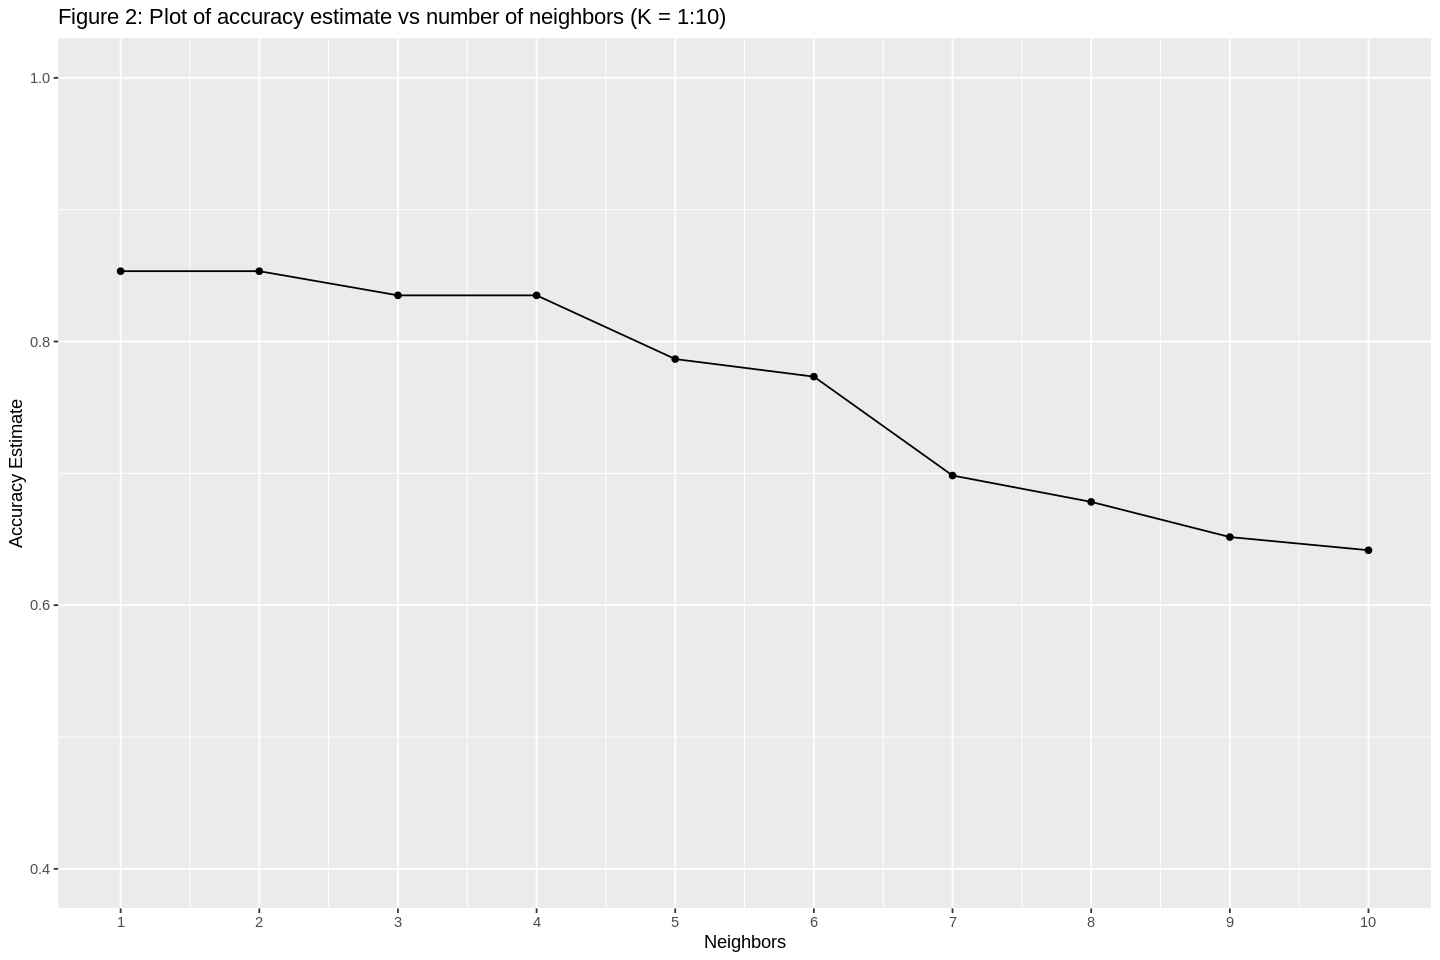

In [84]:
accuracy_versus_k <- ggplot(cleveland_results, aes(x = neighbors, y = mean)) +
geom_point() +
geom_line() +
labs(x = "Neighbors", y = "Accuracy Estimate") +
scale_x_continuous(breaks = seq(1, 10, by = 1)) +  
scale_y_continuous(limits = c(0.4, 1.0)) +
ggtitle("Figure 2: Plot of accuracy estimate vs number of neighbors (K = 1:10)")
accuracy_versus_k

In Figure 2, we used ggplot to generate a line graph to determine the K value with the highest accuracy. 

K=1 and K=2 would equally produce the highest accuracy (85.3%). We chose not to use K=1 since it would overfit the data by having the model over depend on the training data, decreasing its reliability on predicting new data. However, we also did not select K=2 since it’s an even number, a new observation could be “tied” between two nearest neighbors that are in two different categories. In that case, the new label would be randomly selected. Since K=3 is fairly close (83.5%), we chose this value to bypass the issue of encountering a tie. 

In [80]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
set_engine("kknn") |>
set_mode("classification")

cleveland_fit <- workflow() |>
add_recipe(cleveland_recipe_2) |>
add_model(knn_spec) |>
fit(data = upsampled_cleveland)
cleveland_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(3,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.115
Best kernel: rectangular
Best k: 3

We created a new model specifying our determined K value of 3 and added the model and recipe (generated previously) into a workflow and we fit the balanced data set into the workflow so that we are able to use our fit object in determining the accuracy of the model on the testing set.

In [81]:
cleveland_test_predictions <- predict(cleveland_fit, cleveland_testing) |>
bind_cols(cleveland_testing)

cleveland_prediction_accuracy <- cleveland_test_predictions |>
metrics(truth = num, estimate = .pred_class) |>
filter(.metric == "accuracy")
cleveland_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.4210526


Table 6: Accuracy of our classification model on the testing set 

We used the predict function to assess our models accuracy on the cleveland_testing dataset along with using the bind_cols function so that the predictions are added to the testing dataset. We calculated the accuracy that resulted from our models prediction on the testing dataset by specifying the estimate (.pred_class) and true class (num) in the metrics function and filtering for “accuracy”. The accuracy that our model received was 42%. 

In [82]:
cleveland_mat <- cleveland_test_predictions |>
conf_mat(truth = num, estimate = .pred_class)
cleveland_mat 

          Truth
Prediction  0  1  2  3  4
         0 25  7  3  1  0
         1  7  2  3  2  1
         2  3  0  3  4  1
         3  3  5  0  2  2
         4  2  0  0  0  0

Table 7: Confusion matrix of classification models predictions on testing set

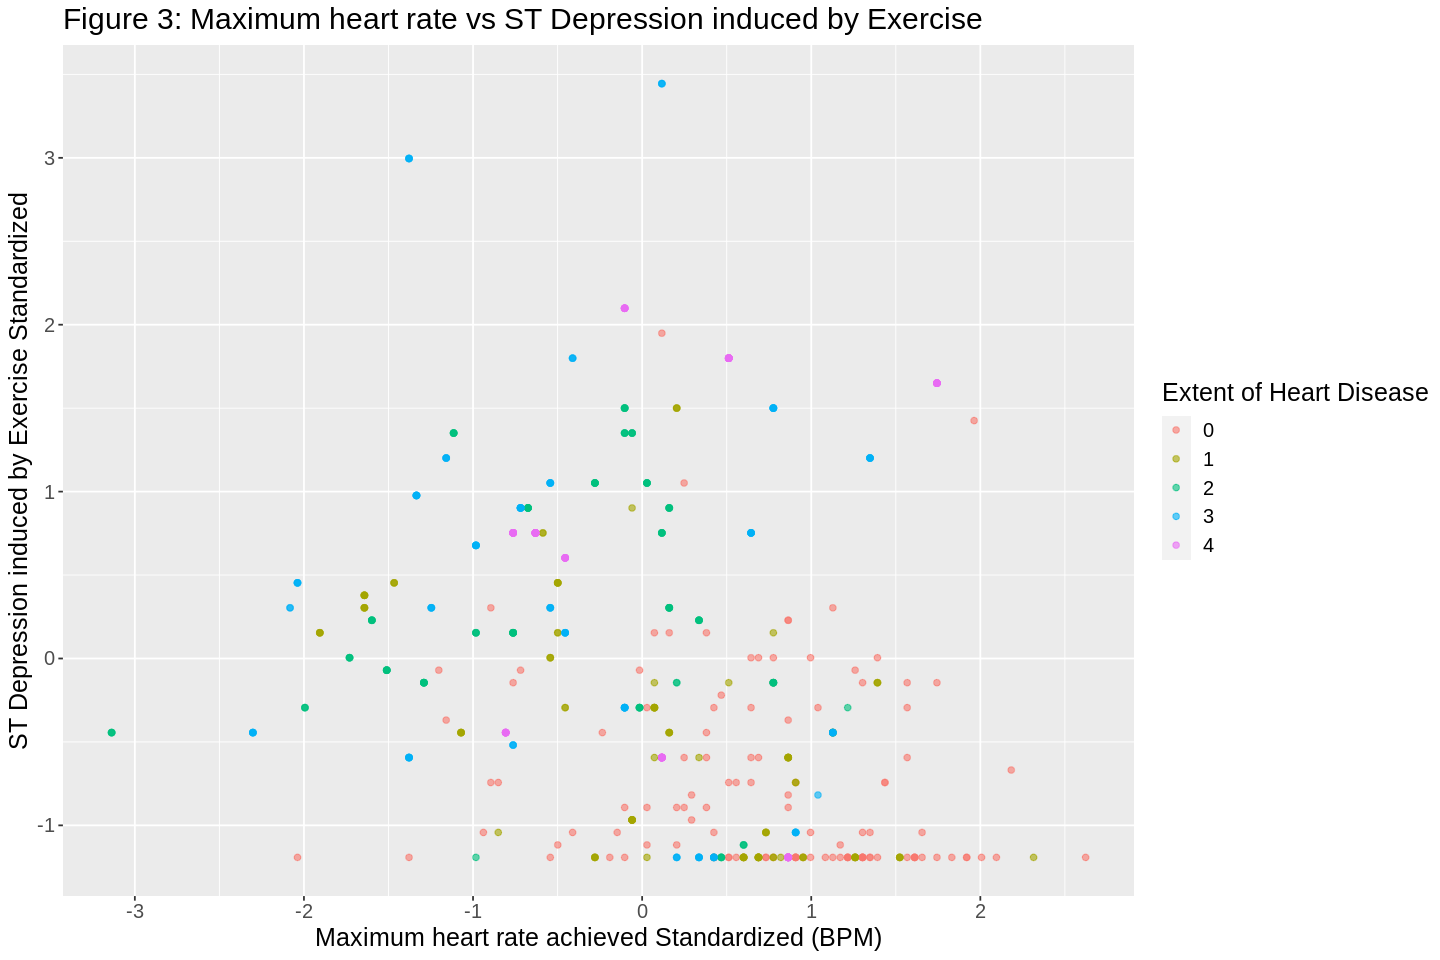

In [85]:
upsampled_cleveland_scaled <- upsampled_cleveland |>
mutate(across(age:thal, scale))

options(repr.plot.height = 8, repr.plot.width = 12)
cleveland_plot <- upsampled_cleveland_scaled |>
ggplot(aes(x = thalach, y = oldpeak, color = num)) +
geom_point(alpha = 0.6) +
labs(x = "Maximum heart rate achieved Standardized (BPM)", y = "ST Depression induced by Exercise Standardized", 
color = "Extent of Heart Disease") +
theme(text = element_text(size = 15)) +
ggtitle("Figure 3: Maximum heart rate vs ST Depression induced by Exercise")
cleveland_plot 

Figure 3 shows a scatter plot of ST depression induced by exercise and maximum heart rate achieved by the extent of heart disease. In our code, we scaled the variables in our balanced data set and created a plot of our predictor variables (ST depression induced by exercise and maximum heart rate achieved) by num (degree of heart disease). 

# Discussion #

Figure 3 illustrates the K-NN classifier built to classify heart disease. There are no clear concentrations of different categories in different sections of the plot, which means a new, unlabeled observation it likely to be tied between two different categories.

According to Table 6, our final model achieved a 42% accuracy, which is better than random guessing but falls short for practical application in determining the risk of heart disease for Cleveland residents. To be useful in real-life scenarios, a higher accuracy percentage (>70%) would be necessary. These findings have the potential to negatively impact patients, as misclassifications can occur, leading to incorrect diagnoses and treatment decisions.The low accuracy of the model raises concerns about its reliability and the potential for both type 1 and type 2 errors. Type 2 errors may result in patients with high degrees of heart disease being misdiagnosed as low-risk, while type 1 errors may lead to individuals without heart disease being identified as having a risk. These errors can have serious consequences for patient health and well-being.

As a group we expected that our model would not yield a high accuracy due to the fact that our dataset did not have many continuous variables that we could apply the K-NN classification algorithm to, so our model was limited to two predictor variables, which are not entirely dependent on their own as a diagnosis of heart disease. 

These findings also prompt future questions and investigations. One avenue for exploration is the inclusion of additional variables, particularly related to nutrition, to improve the classification of heart disease risk, as trans fatty consumption increases risk of clinical coronary heart disease (Micha & Mozafarrian, 2009). Considering factors such as dietary intake, specifically the consumption of trans fatty acids, can enhance our understanding of the relationship between nutrition and heart disease risk. Additionally, addressing the challenge of categorical variables, such as cp, slope, and thal, by transforming them into a continuous format could improve their usability in the classification model. These discussions and investigations can contribute to the development of more accurate and reliable models, leading to improved preventive strategies and personalized healthcare interventions for heart disease.


A limitation of our analysis is that according to the first row in the confusion matrix (Table 4), the model incorrectly predicted many zeroes. This may be due to outliers in the zero category (Figures 2b and 2e) that placed those outlier points closer in proximity to other categories in Figure 4.

# References: #

Fletcher, J. (2022, September 29). ST segment depression: Definition, causes, treatments. Www.medicalnewstoday.com. https://www.medicalnewstoday.com/articles/st-segment-depression

Heart Disease. (2016). Ohio.gov. https://odh.ohio.gov/know-our-programs/heart-disease/heart-disease

Janosi, A., Steinbrunn, W., Pfisterer, M., & Detrano, R. (1988). UCI Machine Learning Repository. Archive.ics.uci.edu. https://archive.ics.uci.edu/dataset/45/heart+disease

Micha, R., & Mozaffarian, D. (2009). Trans fatty acids: effects on metabolic syndrome, heart disease and diabetes. Nature Reviews. Endocrinology, 5(6), 335–344. https://doi.org/10.1038/nrendo.2009.79

Soliman, G. (2018). Dietary Cholesterol and the Lack of Evidence in Cardiovascular Disease. Nutrients, 10(6), 780. https://doi.org/10.3390/nu10060780

Wu, C.-Y., Hu, H.-Y., Chou, Y.-J., Huang, N., Chou, Y.-C., & Li, C.-P. (2015). High Blood Pressure and All-Cause and Cardiovascular Disease Mortalities in Community-Dwelling Older Adults. Medicine, 94(47), e2160. https://doi.org/10.1097/md.0000000000002160

**Variables**
 1. (age) -> age in years
2. (sex) -> sex (1 = male; 0 = female)  
3. (cp) -> cp: chest pain type
4. (trestbps) -> resting blood pressure (in mm Hg on admission to the 
        hospital)
5. (chol) -> serum cholesterol in mg/dl
6. (fbs) -> (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
7. (restecg) -> resting electrocardiographic results
8. (thalach) -> maximum heart rate achieved
9. (exang) -> exercise induced angina 1= yes, 0= no
10. (oldpeak) -> ST depression induced by exercise relative to rest
11. (slope) ->  the slope of the peak exercise ST segment
 Value 1: upsloping
Value 2: flat
Value 3: downsloping
12. (ca) -> number of major vessels (0-3) colored by flourosopy
13. (thal) -> 3= normal, 6= fixed defect, 7= reversible defect
14. (num) -> (the predicted attribute) diagnosis of heart disease
Value 0: < 50% diameter narrowing
Value 1: > 50% diameter narrowing (in any major vessel)
